# LAPD Crime Stats 

## Dataset column descriptions:

source: https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8

<ul>
    <li>dr_no: Division of records number</li>
    <li>date_rptd: Date reported </li>
    <li>date_occ: Date Incident occurred</li>
    <li>time_occ: Time Incident occurred</li>
    <li>area: Police station (numbered 1 - 21)</li>
    <li>area_name: Name of area station</li>
    <li>rpt_dist_no: Reporting district number</li>
    <li>part_1_2: Part I or Part II level offense</li>
    <li>crm_cd: Crime committed</li>
    <li>Crm Cd Desc: Description of crime committed</li>
    <li>Mocodes: Modus Operandi code activity of associated suspect</li>
    <li>Vict Age: Age of victim</li>
    <li>Vict Sex: Sex of victim</li>
        <ul>
            <li>M: Male</li>
            <li>F: Female</li>
            <li>X: Unknown</li>
        </ul>
    <li>Vict Descent: Descent codes:</li>
        <ul>
            <li>A: Other Asian</li>
            <li>B: Black</li>
            <li>C: Chinese</li>
            <li>D: Cambodian</li>
            <li>F: Filipino</li>
            <li>G: Guamanian</li>
            <li>H: Hispanic/Latin/Mexican</li>
            <li>I: American Indian/Alaskan Native</li>
            <li>J: Japanese</li>
            <li>K: Korean</li>
            <li>L: Laotian</li>
            <li>O: Other</li>
            <li>P: Pacific Islander</li>
            <li>S: Samoan</li>
            <li>U: Hawaiian</li>
            <li>V: Vietnamese</li>
            <li>W: White</li>
            <li>X: Unknown</li>
            <li>Z: Asian Indian</li>
        </ul>
    <li>Premis Cd: Type of structure/vehicle/location where crime took place</li>
    <li>Premis Desc: Defines premis code provided</li>
    <li>Weapon Used Cd: Type of weapon used in crime</li>
    <li>Weapon Used Desc: Defines weapon code provided</li>
    <li>Status: status of case</li>
    <li>Status Desc: Description of status</li>
    <li>Crm Cd 1: Indicates code for primary crime committed </li>
    <li>Crm Cd 2: Additional code for crimes committed</li>
    <li>Crm Cd 3: Additional code for crimes committed</li>
    <li>Crm Cd 4: Additional code for crimes committed</li>
    <li>Location: Street address of crime</li>
    <li>Cross Street: Cross street of rounded address</li>
    <li>Lat: Latitude </li>
    <li>Lon: Longitude</li>
</ul>

Several Missing Values exist within the dataset. While some may be intentional (multiple crime codes, if multiple crimes were not committed), others may have been omitted for whatever reason. Two of these values, victim sex and victim descent, may help to identity trends in data that could be valuable in various data analysis. 
Accurate imputation of these values by machine learning may help to provide a reliable estimate to help complete aspects of the dataset. 

In [142]:
import pandas as pd
import numpy as np 

file_path = "/home/francisco/Downloads/Crime_Data_from_2020_to_Present.csv"

df = pd.read_csv(file_path)
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


In [2]:
df.shape

(847725, 28)

In [3]:
df.dtypes

DR_NO               int64
Date Rptd          object
DATE OCC           object
TIME OCC            int64
AREA                int64
AREA NAME          object
Rpt Dist No         int64
Part 1-2            int64
Crm Cd              int64
Crm Cd Desc        object
Mocodes            object
Vict Age            int64
Vict Sex           object
Vict Descent       object
Premis Cd         float64
Premis Desc        object
Weapon Used Cd    float64
Weapon Desc        object
Status             object
Status Desc        object
Crm Cd 1          float64
Crm Cd 2          float64
Crm Cd 3          float64
Crm Cd 4          float64
LOCATION           object
Cross Street       object
LAT               float64
LON               float64
dtype: object

In [4]:
df.isnull().sum()

DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd                 0
Crm Cd Desc            0
Mocodes           117642
Vict Age               0
Vict Sex          111909
Vict Descent      111917
Premis Cd             11
Premis Desc          516
Weapon Used Cd    552364
Weapon Desc       552364
Status                 0
Status Desc            0
Crm Cd 1              11
Crm Cd 2          785497
Crm Cd 3          845623
Crm Cd 4          847663
LOCATION               0
Cross Street      712652
LAT                    0
LON                    0
dtype: int64

## Data Cleaning 
<p>Columns are inconsistently formatted, using underscores, dashes, and literal spaces to denote blank space. Some columns are in all caps. 
Several of these columns contain redundant information by providing both the code and the code description. Crm Cd and Crm Cd 1 refer to the exact same data (With the first being of type int and the latter of type float). 
We can create a dictionary for these values and eliminate the description columns.</p>



In [5]:
np.sort(df['Crm Cd'].unique())

array([110, 113, 121, 122, 210, 220, 230, 231, 235, 236, 237, 250, 251,
       310, 320, 330, 331, 341, 343, 345, 347, 349, 350, 351, 352, 353,
       354, 410, 420, 421, 432, 433, 434, 435, 436, 437, 438, 439, 440,
       441, 442, 443, 444, 445, 446, 450, 451, 452, 470, 471, 473, 474,
       475, 480, 485, 487, 510, 520, 522, 622, 623, 624, 625, 626, 627,
       647, 648, 649, 651, 652, 653, 654, 660, 661, 662, 664, 666, 668,
       670, 740, 745, 753, 755, 756, 760, 761, 762, 763, 805, 806, 810,
       812, 813, 814, 815, 820, 821, 822, 830, 840, 845, 850, 860, 865,
       870, 880, 882, 884, 886, 888, 890, 900, 901, 902, 903, 904, 906,
       910, 920, 921, 922, 924, 928, 930, 931, 932, 933, 940, 942, 943,
       944, 946, 948, 949, 950, 951, 954, 956])

In [6]:
crime_codes = df[['Crm Cd', 'Crm Cd Desc']]
crime_codes.head()

,Crm Cd,Crm Cd Desc
0,624,BATTERY - SIMPLE ASSAULT
1,624,BATTERY - SIMPLE ASSAULT
2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE
3,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER)
4,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA..."


In [7]:
crime_codes  = crime_codes.drop_duplicates()
crime_codes.head()

,Crm Cd,Crm Cd Desc
0,624,BATTERY - SIMPLE ASSAULT
2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE
3,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER)
4,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA..."
5,121,"RAPE, FORCIBLE"


In [8]:
crime_code_list  = [code for code in crime_codes['Crm Cd']]
description_list = [desc for desc in crime_codes['Crm Cd Desc']]

crime_code_dictionary = dict(zip(crime_code_list, description_list))

    

In [9]:
crime_code_dictionary

{624: 'BATTERY - SIMPLE ASSAULT',
 845: 'SEX OFFENDER REGISTRANT OUT OF COMPLIANCE',
 745: 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
 740: 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
 121: 'RAPE, FORCIBLE',
 442: 'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
 946: 'OTHER MISCELLANEOUS CRIME',
 341: 'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
 330: 'BURGLARY FROM VEHICLE',
 930: 'CRIMINAL THREATS - NO WEAPON DISPLAYED',
 648: 'ARSON',
 626: 'INTIMATE PARTNER - SIMPLE ASSAULT',
 440: 'THEFT PLAIN - PETTY ($950 & UNDER)',
 354: 'THEFT OF IDENTITY',
 210: 'ROBBERY',
 230: 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
 310: 'BURGLARY',
 510: 'VEHICLE - STOLEN',
 420: 'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
 761: 'BRANDISH WEAPON',
 236: 'INTIMATE PARTNER - AGGRAVATED ASSAULT',
 662: 'BUNCO, GRAND THEFT',
 350: 'THEFT, PERSON',
 860: 'BATTERY WITH SEXUAL CONTACT',
 480: 'BIKE - STOLEN',
 623: 'BATTERY POLICE (SIMPLE)',
 956: 'LETTERS, LEWD  -  TE

In [10]:
# We can repeat these steps for the other columns that follow the same pattern, in fact...

def create_reference_dictionary(dataframe, column_1, column_2):
    
    temp_df = dataframe[[column_1, column_2]]
    temp_df = temp_df.drop_duplicates()
    temp_df = temp_df.dropna()
    
    column_1_list = [x for x in temp_df[column_1]]
    column_2_list = [x for x in temp_df[column_2]]
    
    return dict(zip(column_1_list, column_2_list))

In [11]:
premis_reference_dictionary = create_reference_dictionary(df, 'Premis Cd', 'Premis Desc')

premis_reference_dictionary = {int(key):value for (key, value) in premis_reference_dictionary.items()}

In [12]:
# Now for Weapons and status

weapon_reference_dictionary = create_reference_dictionary(df, 'Weapon Used Cd', 'Weapon Desc')
status_reference_dictionary = create_reference_dictionary(df, 'Status', 'Status Desc')

weapon_reference_dictionary

{400.0: 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)',
 500.0: 'UNKNOWN WEAPON/OTHER WEAPON',
 306.0: 'ROCK/THROWN OBJECT',
 511.0: 'VERBAL THREAT',
 204.0: 'FOLDING KNIFE',
 302.0: 'BLUNT INSTRUMENT',
 212.0: 'BOTTLE',
 109.0: 'SEMI-AUTOMATIC PISTOL',
 304.0: 'CLUB/BAT',
 218.0: 'OTHER CUTTING INSTRUMENT',
 102.0: 'HAND GUN',
 515.0: 'PHYSICAL PRESENCE',
 307.0: 'VEHICLE',
 216.0: 'SCISSORS',
 308.0: 'STICK',
 215.0: 'MACHETE',
 207.0: 'OTHER KNIFE',
 104.0: 'SHOTGUN',
 200.0: 'KNIFE WITH BLADE 6INCHES OR LESS',
 506.0: 'FIRE',
 214.0: 'ICE PICK',
 221.0: 'GLASS',
 113.0: 'SIMULATED GUN',
 201.0: 'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH',
 504.0: 'DEMAND NOTE',
 501.0: 'BOMB THREAT',
 312.0: 'PIPE/METAL PIPE',
 106.0: 'UNKNOWN FIREARM',
 512.0: 'MACE/PEPPER SPRAY',
 311.0: 'HAMMER',
 208.0: 'RAZOR',
 107.0: 'OTHER FIREARM',
 301.0: 'BELT FLAILING INSTRUMENT/CHAIN',
 223.0: 'UNKNOWN TYPE CUTTING INSTRUMENT',
 219.0: 'SCREWDRIVER',
 205.0: 'KITCHEN KNIFE',
 114.0: 'AIR PISTOL/REVOLV

In [13]:
np.sort(df['Weapon Used Cd'].unique())

array([101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111.,
       112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 200., 201., 202., 203., 204., 205., 206., 207.,
       208., 209., 210., 211., 212., 213., 214., 215., 216., 217., 218.,
       219., 220., 221., 223., 300., 301., 302., 303., 304., 305., 306.,
       307., 308., 309., 310., 311., 312., 400., 500., 501., 502., 503.,
       504., 505., 506., 507., 508., 509., 510., 511., 512., 513., 514.,
       515., 516.,  nan])

In [14]:
# Again, no reason for the dictionary to have floats as keys 

weapon_reference_dictionary = {int(key):value for (key, value) in weapon_reference_dictionary.items()}

In [15]:
weapon_reference_dictionary

{400: 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)',
 500: 'UNKNOWN WEAPON/OTHER WEAPON',
 306: 'ROCK/THROWN OBJECT',
 511: 'VERBAL THREAT',
 204: 'FOLDING KNIFE',
 302: 'BLUNT INSTRUMENT',
 212: 'BOTTLE',
 109: 'SEMI-AUTOMATIC PISTOL',
 304: 'CLUB/BAT',
 218: 'OTHER CUTTING INSTRUMENT',
 102: 'HAND GUN',
 515: 'PHYSICAL PRESENCE',
 307: 'VEHICLE',
 216: 'SCISSORS',
 308: 'STICK',
 215: 'MACHETE',
 207: 'OTHER KNIFE',
 104: 'SHOTGUN',
 200: 'KNIFE WITH BLADE 6INCHES OR LESS',
 506: 'FIRE',
 214: 'ICE PICK',
 221: 'GLASS',
 113: 'SIMULATED GUN',
 201: 'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH',
 504: 'DEMAND NOTE',
 501: 'BOMB THREAT',
 312: 'PIPE/METAL PIPE',
 106: 'UNKNOWN FIREARM',
 512: 'MACE/PEPPER SPRAY',
 311: 'HAMMER',
 208: 'RAZOR',
 107: 'OTHER FIREARM',
 301: 'BELT FLAILING INSTRUMENT/CHAIN',
 223: 'UNKNOWN TYPE CUTTING INSTRUMENT',
 219: 'SCREWDRIVER',
 205: 'KITCHEN KNIFE',
 114: 'AIR PISTOL/REVOLVER/RIFLE/BB GUN',
 303: 'BRASS KNUCKLES',
 101: 'REVOLVER',
 206: 'SWITCH 

Now that we have our reference dictionaries, we no longer need the additional description columns in our dataframe. We can also drop the DR_NO since this is just a record number for the organization.

In [16]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [17]:
columns_to_drop = [
    'DR_NO','Crm Cd Desc', 'Weapon Desc', 
    'Premis Desc', 'Status Desc', 'Crm Cd 1'
]

clean_df = df.drop(columns_to_drop, axis = 1)
clean_df.shape


(847725, 22)

In [18]:
percent_null_values = (clean_df.isnull().sum()) / len(clean_df)

with pd.option_context('display.float_format','{:.2%}'.format):
    display(percent_null_values)

Date Rptd         0.00%
DATE OCC          0.00%
TIME OCC          0.00%
AREA              0.00%
AREA NAME         0.00%
Rpt Dist No       0.00%
Part 1-2          0.00%
Crm Cd            0.00%
Mocodes          13.88%
Vict Age          0.00%
Vict Sex         13.20%
Vict Descent     13.20%
Premis Cd         0.00%
Weapon Used Cd   65.16%
Status            0.00%
Crm Cd 2         92.66%
Crm Cd 3         99.75%
Crm Cd 4         99.99%
LOCATION          0.00%
Cross Street     84.07%
LAT               0.00%
LON               0.00%
dtype: float64

There's something wrong with the Date OCC and Time OCC columns...

In [19]:
df[['DATE OCC', 'TIME OCC']].head(15)


,DATE OCC,TIME OCC
0,01/08/2020 12:00:00 AM,2230
1,01/01/2020 12:00:00 AM,330
2,02/13/2020 12:00:00 AM,1200
3,01/01/2020 12:00:00 AM,1730
4,01/01/2020 12:00:00 AM,415
5,01/01/2020 12:00:00 AM,30
6,01/02/2020 12:00:00 AM,1315
7,01/04/2020 12:00:00 AM,40
8,01/04/2020 12:00:00 AM,200
9,05/26/2020 12:00:00 AM,1925


In [20]:
df['DATE OCC'][0][:10]

'01/08/2020'

In [21]:
new_dates = [date[:10] for date in clean_df['DATE OCC'].values ]

In [22]:
clean_df['date_occurred'] = new_dates

In [23]:
clean_df[['DATE OCC','date_occurred']].head(10)

,DATE OCC,date_occurred
0,01/08/2020 12:00:00 AM,01/08/2020
1,01/01/2020 12:00:00 AM,01/01/2020
2,02/13/2020 12:00:00 AM,02/13/2020
3,01/01/2020 12:00:00 AM,01/01/2020
4,01/01/2020 12:00:00 AM,01/01/2020
5,01/01/2020 12:00:00 AM,01/01/2020
6,01/02/2020 12:00:00 AM,01/02/2020
7,01/04/2020 12:00:00 AM,01/04/2020
8,01/04/2020 12:00:00 AM,01/04/2020
9,05/26/2020 12:00:00 AM,05/26/2020


That's much better.
We also have 6 columns dedicated to the location, which is a bit much considering we can derive most of these data by just the Lat and Long coordinates.
We'll drop the original date occ column, along with the 4 columns for area that are NOT lat and long. 

In [24]:
columns_to_drop = [
    'DATE OCC', 'AREA', 'AREA NAME',
    'LOCATION', 'Cross Street'
]

clean_df = clean_df.drop(columns_to_drop, axis = 1)
clean_df.head(10)

,Date Rptd,TIME OCC,Rpt Dist No,Part 1-2,Crm Cd,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Weapon Used Cd,Status,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON,date_occurred
0,01/08/2020 12:00:00 AM,2230,377,2,624,0444 0913,36,F,B,501.0,400.0,AO,NaN,NaN,NaN,34.0141,-118.2978,01/08/2020
1,01/02/2020 12:00:00 AM,330,163,2,624,0416 1822 1414,25,M,H,102.0,500.0,IC,NaN,NaN,NaN,34.0459,-118.2545,01/01/2020
2,04/14/2020 12:00:00 AM,1200,155,2,845,1501,0,X,X,726.0,NaN,AA,NaN,NaN,NaN,34.0448,-118.2474,02/13/2020
3,01/01/2020 12:00:00 AM,1730,1543,2,745,0329 1402,76,F,W,502.0,NaN,IC,998.0,NaN,NaN,34.1685,-118.4019,01/01/2020
4,01/01/2020 12:00:00 AM,415,1998,2,740,0329,31,X,X,409.0,NaN,IC,NaN,NaN,NaN,34.2198,-118.4468,01/01/2020
5,01/02/2020 12:00:00 AM,30,163,1,121,0413 1822 1262 1415,25,F,H,735.0,500.0,IC,998.0,NaN,NaN,34.0452,-118.2534,01/01/2020
6,01/02/2020 12:00:00 AM,1315,161,1,442,1402 2004 0344 0387,23,M,H,404.0,NaN,IC,998.0,NaN,NaN,34.0483,-118.2631,01/02/2020
7,01/04/2020 12:00:00 AM,40,155,2,946,1402 0392,0,X,X,726.0,NaN,IC,998.0,NaN,NaN,34.0448,-118.2474,01/04/2020
8,01/04/2020 12:00:00 AM,200,101,1,341,1822 0344 1402,23,M,B,502.0,NaN,IC,998.0,NaN,NaN,34.0677,-118.2398,01/04/2020
9,06/19/2020 12:00:00 AM,1925,1708,1,341,1300 0202 0378 0325,0,X,X,203.0,NaN,AO,NaN,NaN,NaN,34.2864,-118.5021,05/26/2020


Much better! The values in Premis Cd, Weapon Used Cd, and the Crm Cd 2/3/4 columns still need to be updated to ints. We can also fill any of the null values with 0, since all of the coded values have three digits. 

In [25]:
percent_null_values = (clean_df.isnull().sum()) / len(clean_df)

with pd.option_context('display.float_format','{:.2%}'.format):
    display(percent_null_values)

Date Rptd         0.00%
TIME OCC          0.00%
Rpt Dist No       0.00%
Part 1-2          0.00%
Crm Cd            0.00%
Mocodes          13.88%
Vict Age          0.00%
Vict Sex         13.20%
Vict Descent     13.20%
Premis Cd         0.00%
Weapon Used Cd   65.16%
Status            0.00%
Crm Cd 2         92.66%
Crm Cd 3         99.75%
Crm Cd 4         99.99%
LAT               0.00%
LON               0.00%
date_occurred     0.00%
dtype: float64

In [26]:
clean_df['Vict Sex'].value_counts()

Vict Sex
M    349347
F    311659
X     74716
H        93
-         1
Name: count, dtype: int64

In [27]:
# H??? That wasn't in the documentation 

mysterious_biology = clean_df[clean_df['Vict Sex'] == 'H']
mysterious_biology.head(10)

,Date Rptd,TIME OCC,Rpt Dist No,Part 1-2,Crm Cd,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Weapon Used Cd,Status,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON,date_occurred
1511,01/03/2020 12:00:00 AM,2200,237,2,740,0329,25,H,F,103.0,NaN,IC,NaN,NaN,NaN,34.0613,-118.2638,01/03/2020
1840,01/20/2020 12:00:00 AM,40,238,1,251,1822 0450 1402,35,H,H,502.0,500.0,IC,998.0,NaN,NaN,34.0616,-118.2586,01/20/2020
4589,01/08/2020 12:00:00 AM,1100,566,2,624,1309 0416 0429 0603 0361 0913,27,H,H,502.0,400.0,IC,NaN,NaN,NaN,33.7333,-118.2814,01/07/2020
17720,10/05/2020 12:00:00 AM,200,769,1,230,0913 0906 0416 1218 1805,35,H,H,101.0,312.0,IC,NaN,NaN,NaN,34.0454,-118.3189,10/05/2020
19368,04/14/2020 12:00:00 AM,1300,721,1,330,0344,33,H,F,101.0,NaN,IC,NaN,NaN,NaN,34.0709,-118.3764,04/14/2020
93800,10/30/2020 12:00:00 AM,1155,909,2,354,0377 0100,59,H,F,248.0,NaN,IC,NaN,NaN,NaN,34.2071,-118.4298,10/30/2020
110175,11/29/2020 12:00:00 AM,1530,2088,2,626,0913 2000 1243 0416 0305,25,H,H,502.0,400.0,AO,NaN,NaN,NaN,34.0418,-118.2852,11/29/2020
127579,05/18/2020 12:00:00 AM,1630,1846,2,354,1822 0100 0930,36,H,B,502.0,NaN,IC,NaN,NaN,NaN,33.9332,-118.2485,05/17/2020
135838,05/13/2020 12:00:00 AM,1716,1322,1,440,0344,49,H,F,145.0,NaN,IC,NaN,NaN,NaN,34.0254,-118.2629,05/09/2020
147269,10/04/2020 12:00:00 AM,1530,1555,1,330,0344 1300,45,H,F,101.0,NaN,IC,NaN,NaN,NaN,34.1545,-118.3703,10/02/2020


In [28]:
for crime in mysterious_biology['Crm Cd']:
    print(f'{crime}: {crime_code_dictionary[crime]}')

740: VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)
251: SHOTS FIRED AT INHABITED DWELLING
624: BATTERY - SIMPLE ASSAULT
230: ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
330: BURGLARY FROM VEHICLE
354: THEFT OF IDENTITY
626: INTIMATE PARTNER - SIMPLE ASSAULT
354: THEFT OF IDENTITY
440: THEFT PLAIN - PETTY ($950 & UNDER)
330: BURGLARY FROM VEHICLE
440: THEFT PLAIN - PETTY ($950 & UNDER)
210: ROBBERY
410: BURGLARY FROM VEHICLE, ATTEMPTED
230: ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
330: BURGLARY FROM VEHICLE
330: BURGLARY FROM VEHICLE
231: ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER
330: BURGLARY FROM VEHICLE
624: BATTERY - SIMPLE ASSAULT
354: THEFT OF IDENTITY
330: BURGLARY FROM VEHICLE
624: BATTERY - SIMPLE ASSAULT
330: BURGLARY FROM VEHICLE
330: BURGLARY FROM VEHICLE
440: THEFT PLAIN - PETTY ($950 & UNDER)
901: VIOLATION OF RESTRAINING ORDER
331: THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)
354: THEFT OF IDENTITY
230: ASSAULT WITH DEADLY WEAPON, AGGRAVATED A

Considering an H value for victim sex is not listed in any documentation, and how unlikely it would be for an intersex victim to be identified by an H, we'll change these values to unknown (X)

In [29]:
# Taking care of all of the remaining null values 

# Both Vict Sex and Vict Descent have the same number of null values, while not stated explicitly, the documentation suggests these are crimes against property/things
clean_df['Vict Sex'] = clean_df['Vict Sex'].str.replace('H','X')
clean_df['Vict Sex'] = clean_df['Vict Sex'].str.replace('-','X')
clean_df['Vict Sex'] = clean_df['Vict Sex'].fillna('X')
clean_df['Vict Descent'] = clean_df['Vict Descent'].fillna('X')

clean_df['Mocodes'] = clean_df['Mocodes'].fillna(0)
clean_df['Weapon Used Cd'] = clean_df['Weapon Used Cd'].fillna(0)
clean_df['Crm Cd 2'] = clean_df['Crm Cd 2'].fillna(0)
clean_df['Crm Cd 3'] = clean_df['Crm Cd 3'].fillna(0)
clean_df['Crm Cd 4'] = clean_df['Crm Cd 4'].fillna(0)

In [30]:
percent_null_values = (clean_df.isnull().sum()) / len(clean_df)

with pd.option_context('display.float_format','{:.2%}'.format):
    display(percent_null_values)

Date Rptd        0.00%
TIME OCC         0.00%
Rpt Dist No      0.00%
Part 1-2         0.00%
Crm Cd           0.00%
Mocodes          0.00%
Vict Age         0.00%
Vict Sex         0.00%
Vict Descent     0.00%
Premis Cd        0.00%
Weapon Used Cd   0.00%
Status           0.00%
Crm Cd 2         0.00%
Crm Cd 3         0.00%
Crm Cd 4         0.00%
LAT              0.00%
LON              0.00%
date_occurred    0.00%
dtype: float64

In [31]:
# Convert the floats to ints 

clean_df['Premis Cd'] = clean_df['Premis Cd'].convert_dtypes()


In [32]:
clean_df['Premis Cd'].unique()

<IntegerArray>
[501, 102, 726, 502, 409, 735, 404, 203, 101, 108,
 ...
 889, 240, 805, 126, 734, 894, 836, 976, 972, 973]
Length: 314, dtype: Int64

In [33]:
# To avoid unnecessary repeats

def convert_and_fill_nulls(series):
    series = series.convert_dtypes()
    series = series.fillna(0)
    return series

In [34]:
clean_df['Premis Cd'] = clean_df['Premis Cd'].fillna(0)

clean_df['Weapon Used Cd'] = convert_and_fill_nulls(clean_df['Weapon Used Cd'])

clean_df['Crm Cd 2'] = convert_and_fill_nulls(clean_df['Crm Cd 2'])

clean_df['Crm Cd 3'] = convert_and_fill_nulls(clean_df['Crm Cd 3'])

clean_df['Crm Cd 4'] = convert_and_fill_nulls(clean_df['Crm Cd 4'])

In [35]:
clean_df.dtypes

Date Rptd          object
TIME OCC            int64
Rpt Dist No         int64
Part 1-2            int64
Crm Cd              int64
Mocodes            object
Vict Age            int64
Vict Sex           object
Vict Descent       object
Premis Cd           Int64
Weapon Used Cd      Int64
Status             object
Crm Cd 2            Int64
Crm Cd 3            Int64
Crm Cd 4            Int64
LAT               float64
LON               float64
date_occurred      object
dtype: object

### We're almost ready for analysis! 
<ul>A few things left to clean up:
    <li>Change the date occured colum to a date format</li>
    <li>Reorder and rename the columns for consistency</li>

</ul>

In [36]:
clean_df['date_occurred'] = pd.to_datetime(clean_df['date_occurred'])
clean_df['date_reported'] = pd.to_datetime(clean_df['Date Rptd'])

/tmp/ipykernel_8593/493504116.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  more_cleaner_df['date_reported'] = pd.to_datetime(more_cleaner_df['Date Rptd'])


To consolidate the information in date occurred and date reported into valuable data, we'll create a new column indicating the amount of time that passed before the crime was actually reported 

In [37]:

reporting_lag = clean_df['date_reported'] - clean_df['date_occurred']
clean_df['reporting_lag'] = reporting_lag

In [38]:
rename_dictionary = {
    'TIME OCC':'time_occurred',
    'Part 1-2':'part_offense',
    'Rpt Dist No':'reporting_district',
    'Crm Cd':'crime_code',
    'Mocodes':'mo_codes',
    'Vict Age':'victim_age',
    'Vict Sex':'victim_sex',
    'Vict Descent':'victim_descent',
    'Premis Cd':'premises_code',
    'Weapon Used Cd':'weapon_used_code',
    'Status':'status_code',
    'Crm Cd 2':'crime_code_2',
    'Crm Cd 3':'crime_code_3',
    'Crm Cd 4':'crime_code_4',
    'LAT':'latitude',
    'LON':'longitude'
}

In [39]:
clean_df = clean_df.rename(columns = rename_dictionary)

clean_df.columns

Index(['Date Rptd', 'time_occurred', 'reporting_district', 'part_offense',
       'crime_code', 'mo_codes', 'victim_age', 'victim_sex', 'victim_descent',
       'premises_code', 'weapon_used_code', 'status_code', 'crime_code_2',
       'crime_code_3', 'crime_code_4', 'latitude', 'longitude',
       'date_occurred', 'date_reported', 'reporting_lag'],
      dtype='object')

In [40]:

clean_df = clean_df.drop(['Date Rptd', 'date_occurred','date_reported'], axis = 1)

The amount of MO Codes per incident varies greatly across the dataset, and may indicate how complete each incident report could be. In this case, we'll change the MO code column to indicate how many different MO Codes were reported with each incident. 

In [41]:
mcs = (clean_df['mo_codes'])

str_mcs = [str(x) for x in mcs]

new_list = [list(x.split(" ")) for x in str_mcs]

lens = [len(x) for x in new_list]
clean_df['mo_codes_reported'] = lens

In [42]:
clean_df = clean_df[['time_occurred', 'part_offense', 'crime_code', 'crime_code_2', 
                            'crime_code_3', 'crime_code_4', 'victim_age', 'victim_sex', 'victim_descent', 
                            'weapon_used_code', 'premises_code', 'status_code', 'reporting_district', 'reporting_lag',
                            'mo_codes_reported', 'latitude', 'longitude']]

clean_df.head()

,time_occurred,part_offense,crime_code,crime_code_2,crime_code_3,crime_code_4,victim_age,victim_sex,victim_descent,weapon_used_code,premises_code,status_code,reporting_district,reporting_lag,mo_codes_reported,latitude,longitude
0,2230,2,624,0,0,0,36,F,B,400,501,AO,377,0 days,2,34.0141,-118.2978
1,330,2,624,0,0,0,25,M,H,500,102,IC,163,1 days,3,34.0459,-118.2545
2,1200,2,845,0,0,0,0,X,X,0,726,AA,155,61 days,1,34.0448,-118.2474
3,1730,2,745,998,0,0,76,F,W,0,502,IC,1543,0 days,2,34.1685,-118.4019
4,415,2,740,0,0,0,31,X,X,0,409,IC,1998,0 days,1,34.2198,-118.4468


In [143]:
# vs what we started with 
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


We'll also pickle the reference dictionaries for future use 

In [ ]:
import pickle 


with open('crime_code_reference.pickle', 'wb') as file:
    pickle.dump(crime_code_dictionary, file, protocol=pickle.HIGHEST_PROTOCOL)


with open('weapon_reference_dictionary.pkl', 'wb') as file:
    pickle.dump(weapon_reference_dictionary, file, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('status_reference_dictionary.pkl', 'wb') as file:
    pickle.dump(status_reference_dictionary, file, protocol=pickle.HIGHEST_PROTOCOL)
    

with open('premis_reference_dictionary.pkl', 'wb') as file:
    pickle.dump(premis_reference_dictionary, file, protocol=pickle.HIGHEST_PROTOCOL)
    

## Data Selection
A large portion of the dataset only has a single crime code associated with it, so utilizing data with 2 crime codes may provide more insight while reducing the amount of data to work with to a more manageable level (at least, for this particular project)

In [43]:
clean_df['crime_code_2'].value_counts()

crime_code_2
0      785497
998     49745
930      3476
860      1198
761       888
        ...  
943         1
972         1
942         1
950         1
438         1
Name: count, Length: 125, dtype: Int64

In [44]:
multi_crime = clean_df.drop(['crime_code_3','crime_code_4'],axis=1)
multi_crime = multi_crime[multi_crime['crime_code_2'] > 0]
multi_crime.info

<bound method DataFrame.info of         time_occurred  part_offense  crime_code  crime_code_2  victim_age  \
3                1730             2         745           998          76   
5                  30             1         121           998          25   
6                1315             1         442           998          23   
7                  40             2         946           998           0   
8                 200             1         341           998          23   
...               ...           ...         ...           ...         ...   
847574           2030             2         624           946          56   
847601           1055             1         230           998          39   
847614           2130             1         121           998          30   
847709           1400             1         210           624          23   
847718            755             1         310           998          54   

       victim_sex victim_descent  weapon_us

In [47]:
multi_crime['victim_sex'].value_counts()

victim_sex
M    32057
F    21152
X     9019
Name: count, dtype: int64

In [48]:
multi_crime['victim_descent'].value_counts()

victim_descent
H    23948
W    11631
X    10128
B     9618
O     5317
A     1415
K       87
F       32
C       15
J        8
P        7
I        5
G        5
Z        4
V        3
D        2
U        2
S        1
Name: count, dtype: int64

In [68]:
np.sort(multi_crime['mo_codes_reported'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [72]:
multi_crime['victim_sex'].value_counts()

victim_sex
M    32057
F    21152
X     9019
Name: count, dtype: int64

<Axes: xlabel='mo_codes_reported'>

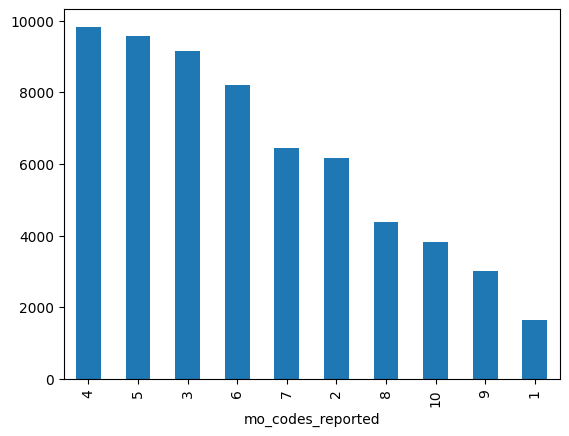

In [95]:
import matplotlib.pyplot as plt 

multi_crime['mo_codes_reported'].value_counts().plot(kind='bar')

<Axes: xlabel='mo_codes_reported'>

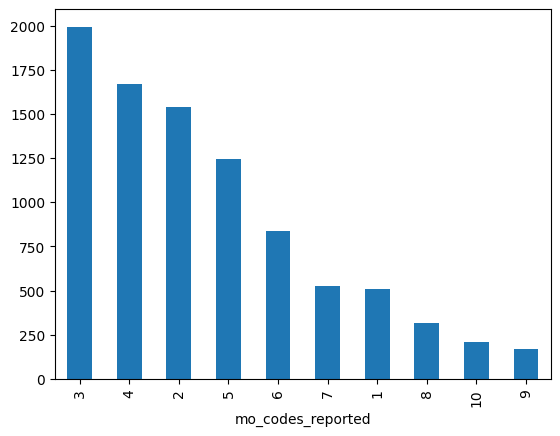

In [96]:
unknown_vs = multi_crime[multi_crime['victim_sex'] == 'X']

unknown_vs['mo_codes_reported'].value_counts().plot(kind='bar')

<Axes: xlabel='mo_codes_reported'>

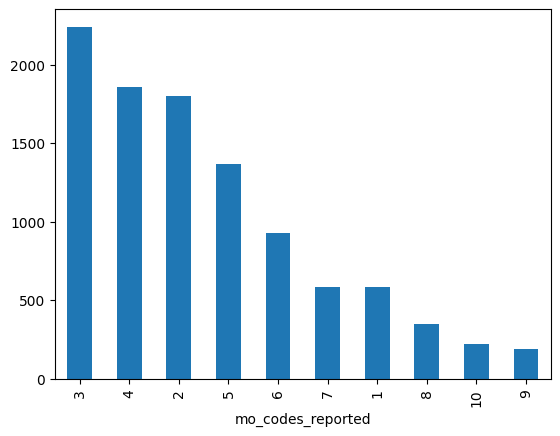

In [97]:
unknown_vd = multi_crime[multi_crime['victim_descent'] == 'X']
unknown_vd['mo_codes_reported'].value_counts().plot(kind='bar')

Our final dataset to utilize will ensure both victim sex and victim descent are not unknown.

In [104]:
data = multi_crime.loc[(multi_crime['victim_sex'] != 'X') & (multi_crime['victim_descent'] != 'X')]
print(data.shape)
data.head()

(52073, 15)


,time_occurred,part_offense,crime_code,crime_code_2,victim_age,victim_sex,victim_descent,weapon_used_code,premises_code,status_code,reporting_district,reporting_lag,mo_codes_reported,latitude,longitude
3,1730,2,745,998,76,F,W,0,502,IC,1543,0 days,2,34.1685,-118.4019
5,30,1,121,998,25,F,H,500,735,IC,163,1 days,4,34.0452,-118.2534
6,1315,1,442,998,23,M,H,0,404,IC,161,0 days,4,34.0483,-118.2631
8,200,1,341,998,23,M,B,0,502,IC,101,0 days,3,34.0677,-118.2398
17,1900,1,440,624,29,F,W,400,102,IC,511,0 days,5,33.7926,-118.3043


In [105]:
data.to_pickle('./ml_crime_data.pkl')

In [132]:
unknown_vd.to_pickle('./unknown_victim_descent.pkl')

## Building the ML Model

In [117]:
# Starting with the selected cleaned data set 

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

file_path = './ml_crime_data.pkl' 

df = pd.read_pickle(file_path)

df['crime_code'] = [code // 100 for code in df['crime_code']]
df['crime_code_2'] = [code // 100 for code in df['crime_code_2']]
df['weapon_used_code'] = [code // 100 for code in df['weapon_used_code']]
df['premises_code'] = [code // 100 for code in df['premises_code']]

mm_scaler = MinMaxScaler()

df['victim_age'] = mm_scaler.fit_transform(np.array(df['victim_age']).reshape(-1,1))
df['latitude'] = mm_scaler.fit_transform(np.array(df['latitude']).reshape(-1,1))   
df['longitude'] = mm_scaler.fit_transform(np.array(df['longitude']).reshape(-1,1))
df['reporting_lag'] = mm_scaler.fit_transform(np.array(df['reporting_lag']).reshape(-1,1))

ss_scaler = StandardScaler()
df['mo_codes_reported'] = ss_scaler.fit_transform(np.array(df['mo_codes_reported']).reshape(-1,1))
df['time_occurred'] = ss_scaler.fit_transform(np.array(df['time_occurred']).reshape(-1,1))


df = df.drop(['status_code','reporting_district'],axis=1)


df['victim_sex'] = df['victim_sex'].astype('str')
df['victim_descent'] = df['victim_descent'].astype('str')


df['victim_sex'] = df['victim_sex'].apply(lambda x: x.replace(x,'-1') if x=='M' else x.replace(x,'1')).astype('float')

df['victim_descent'] = df['victim_descent'].apply(lambda x: x.replace(x,'-1') if x=='W' else x.replace(x, '1')).astype('float')

In [8]:
# for x in new_list:
#     while len(x) < 10:
#         x.append(0)

# mo_code_arr = [np.array(x) for x in new_list]
# mo_code_arr = np.asarray(mo_code_arr)
# mo_code_arr.shape

In [9]:
# mo_code_df = pd.DataFrame(mo_code_arr, columns=['mo_code_1','mo_code_2','mo_code_3','mo_code_4','mo_code_5','mo_code_6','mo_code_7','mo_code_8','mo_code_9','mo_code_10'],dtype='float')
# df = df.join(mo_code_df)


In [118]:
from sklearn.model_selection import train_test_split

X = np.asarray(df.drop('victim_sex',axis=1))
y = np.asarray(df['victim_sex'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [110]:
X_train.shape

(41658, 12)

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


params = {'n_estimators':[100,250,500],
          'criterion':['gini','entropy'],
          'max_features':['sqrt','log2'],
          'ccp_alpha':[0.0,0.01,0.05,0.1]}

clf = RandomForestClassifier(verbose=1,n_jobs=-1)
grid = GridSearchCV(clf,params)
grid.fit(X_train,y_train)

print(grid.best_params_)
print(grid.best_score_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.


{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 500}
0.7135483715565178


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished


In [119]:
params = {'n_estimators':[250,500,750],
          'criterion':['gini','entropy'],
          'max_depth':[2,4,8],
          'min_samples_leaf':[1,2,4],
          'ccp_alpha':[0.0,0.01]}

clf = RandomForestClassifier(verbose=1,n_jobs=-1)
grid = GridSearchCV(clf,params)
grid.fit(X_train,y_train)

print(grid.best_params_)
print(grid.best_score_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 500}
0.713260472413793


[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


In [ ]:
from sklearn.svm import LinearSVC


params = {'C':[0.1,0.5,0.8,1,5,8]}
         


clf = LinearSVC(verbose=1, max_iter=10000)
grid = GridSearchCV(clf, params)
grid.fit(X_train,y_train)

print(grid.best_params_)
print(grid.best_score_)


In [122]:
from sklearn.ensemble import AdaBoostClassifier

params = {'n_estimators':[50,100,150,300,500]}

clf = AdaBoostClassifier()
grid = GridSearchCV(clf,params)
grid.fit(X_train,y_train)


print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 500}
0.7038264789993335


In [123]:
params = {'n_estimators':[500,1000,3000,5000]}

clf = AdaBoostClassifier()
grid = GridSearchCV(clf,params)
grid.fit(X_train,y_train)


print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 500}
0.7038264789993335


So far none of the supervised learning methods have produced a high enough training score to use for imputation of missing victim sex values. We can attempt to predict the victim descent instead, using the most accurate methods so far.

In [125]:
X = np.asarray(df.drop('victim_descent',axis=1))
y = np.asarray(df['victim_descent'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [126]:
params = {'n_estimators':[250,500],
          'criterion':['gini','entropy'],
          'max_depth':[2,4,8],
          'min_samples_leaf':[1,2,4]
          }

clf = RandomForestClassifier(verbose=1,n_jobs=-1)
grid = GridSearchCV(clf,params)
grid.fit(X_train,y_train)

print(grid.best_params_)
print(grid.best_score_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 500}
0.7944213530052456


[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


In [127]:
params = {
          'max_depth':[8,12,16],
          'min_samples_leaf':[1,2,4]}

clf = RandomForestClassifier(n_estimators=500,criterion='gini',verbose=1,n_jobs=-1)
grid = GridSearchCV(clf,params)
grid.fit(X_train,y_train)

print(grid.best_params_)
print(grid.best_score_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Do

{'max_depth': 16, 'min_samples_leaf': 2}
0.8009266761760024


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.2s finished


In [128]:
params = {
          'max_depth':[16,32,64],
          'min_samples_leaf':[1,2,4]}

clf = RandomForestClassifier(n_estimators=500,criterion='gini',verbose=1,n_jobs=-1)
grid = GridSearchCV(clf,params)
grid.fit(X_train,y_train)

print(grid.best_params_)
print(grid.best_score_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Do

{'max_depth': 16, 'min_samples_leaf': 4}
0.8006386272073607


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.3s finished


In [129]:
clf = RandomForestClassifier(n_estimators=500,criterion='gini',max_depth=16,min_samples_leaf=4,n_jobs=-1,verbose=1)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 500 out of 500 | elapsed:    0.1s finished


0.8036485837734038

In [130]:
from joblib import dump, load

dump(clf,'vdescent_classifier.joblib')

['vdescent_classifier.joblib']

In [147]:
def predict_victim_descent(clf, data):
    df = data.copy()
    df['crime_code'] = [code // 100 for code in df['crime_code']]
    df['crime_code_2'] = [code // 100 for code in df['crime_code_2']]
    df['weapon_used_code'] = [code // 100 for code in df['weapon_used_code']]
    df['premises_code'] = [code // 100 for code in df['premises_code']]

    mm_scaler = MinMaxScaler()

    df['victim_age'] = mm_scaler.fit_transform(np.array(df['victim_age']).reshape(-1,1))
    df['latitude'] = mm_scaler.fit_transform(np.array(df['latitude']).reshape(-1,1))   
    df['longitude'] = mm_scaler.fit_transform(np.array(df['longitude']).reshape(-1,1))
    df['reporting_lag'] = mm_scaler.fit_transform(np.array(df['reporting_lag']).reshape(-1,1))

    ss_scaler = StandardScaler()
    df['mo_codes_reported'] = ss_scaler.fit_transform(np.array(df['mo_codes_reported']).reshape(-1,1))
    df['time_occurred'] = ss_scaler.fit_transform(np.array(df['time_occurred']).reshape(-1,1))

    
    df = df.drop(['victim_descent','status_code','reporting_district'],axis=1)
    df['victim_sex'] = df['victim_sex'].astype('str')
    df['victim_sex'] = df['victim_sex'].apply(lambda x: x.replace(x,'-1') if x=='M' else x.replace(x,'1')).astype('float')

    
    x = np.array(df)
    predictions = clf.predict(x)
    converted_predictions = []
    for prediction in predictions:
        if prediction == -1:
            converted_predictions.append('W')
        else:
            converted_predictions.append('M')

    data['victim_descent'] = converted_predictions
    return data
 

Predicted victim descent will either be W for white, or M for minority 

In [148]:
data = pd.read_pickle('./unknown_victim_descent.pkl')

predicted_data = predict_victim_descent(clf,data)

predicted_data.head()

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 500 out of 500 | elapsed:    0.1s finished


,time_occurred,part_offense,crime_code,crime_code_2,victim_age,victim_sex,victim_descent,weapon_used_code,premises_code,status_code,reporting_district,reporting_lag,mo_codes_reported,latitude,longitude
7,40,2,946,998,0,X,M,0,726,IC,155,0 days,2,34.0448,-118.2474
13,1638,1,648,998,0,X,M,500,404,IC,162,0 days,3,34.0480,-118.2577
291,1900,2,649,998,0,X,M,0,101,AA,636,0 days,1,34.1039,-118.3318
512,1445,1,220,998,0,M,M,504,602,IC,152,0 days,6,34.0487,-118.2571
680,2030,2,740,998,0,X,M,0,502,AA,1105,0 days,5,34.1442,-118.2180


In [149]:
predicted_data['victim_descent'].value_counts()

victim_descent
M    9835
W     293
Name: count, dtype: int64

## Dicussion & Conclusion

In this case, any supervised learning model attempted was not reliably accurate to predict victim sex based on the chosen data, and was only moderatly more successful at predicting victim descent instead (~ 80%). Other models attempted but not shown (to reduce notebook size and output) included testing several SVC models and Grid Searches to find the potential best parameters. These models either failed to converge or capped out at around 65 to 70%. 

Continued attempts to rework the data being used for the model could prove useful, along with model selection and methodology that may be outside of the scope of strictly supervised machine learning methods. 